In [ ]:
!apt install -y ffmpeg
!pip install eyed3
!pip install pydub
!pip install pyAudioAnalysis
!pip install tensorflow-gpu

import os
import tensorflow as tf
import numpy as np
import pandas as pd
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
     |████████████████████████████████| 153kB 3.5MB/s 
     |████████████████████████████████| 41.2MB 103kB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.2-cp36-none-any.whl size=41160898 sha256=f4c24ea1eafaf9c97021f7999f28114308cae0e69bc5892da150d24a580beec5
  Stored in directory: /root/.cache/pip/wheels/3d/2e/91/25ef2f2507b62132d1c66206642e7541025115873b5d270b0a
Successfully built pyAudioAnalysis
     |████████████████████████████████| 421.8MB 27kB/s 
     |████████████████████████████████| 450kB 30.7MB/s 
     |████████████████████████████████| 3.9MB 37.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=36737ec1d254d9f87689d880f058f3dd437f18ca9d11781c978b46306f47e605
  Stored in directory: /root/.cache/

In [ ]:
def preProcess( fileName ):
    # Extracting wav file data
    [Fs, x] = audioBasicIO.read_audio_file(fileName);

    # If double channel data then take mean
    if( len( x.shape ) > 1 and  x.shape[1] == 2 ):
        x = np.mean( x, axis = 1, keepdims = True )
    else:
        x = x.reshape( x.shape[0], 1 )
    
    # Extract the raw chromagram data, expected dimention is [ m,  ] not [ m, 1 ]
    F, f_names = ShortTermFeatures.feature_extraction(
        x[ :, 0 ], 
        Fs, 0.050*Fs, 
        0.025*Fs
    )
    
    return (f_names, F)

In [ ]:
def getChromagram( audioData ):
    # chronograph_1
    temp_data =  audioData[ 21 ].reshape( 1, audioData[ 21 ].shape[0] )
    chronograph = temp_data
    
    # looping through the next 11 stacking them vertically
    for i in range( 22, 33 ):
        temp_data =  audioData[ i ].reshape( 1, audioData[ i ].shape[0] )
        chronograph = np.vstack( [ chronograph,  temp_data ] )
    
    return chronograph

In [ ]:
def getNoteFrequency( chromagram ):
    
    # Total number of time frames in the current sample
    numberOfWindows = chromagram.shape[1]
    
    # Taking the note with the highest amplitude
    freqVal = chromagram.argmax( axis = 0 )
    
    # Converting the freqVal vs time to freq count
    histogram, bin = np.histogram( freqVal, bins = 12 ) 
    
    # Normalizing the distribution by the number of time frames
    normalized_hist = histogram.reshape( 1, 12 ).astype( float ) / numberOfWindows
    
    return normalized_hist

In [ ]:
def plotHeatmap( chromagraph, smallSample = True ):
    
    notesLabels = [ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]
    
    fig, axis = plt.subplots()
    
    if smallSample:
        im = axis.imshow( chromagram[ :, 0 : 25 ], cmap = "YlGn" )
    else:
        im = axis.imshow( chromagram )
        
    cbar = axis.figure.colorbar(im, ax = axis,  cmap = "YlGn")
    cbar.ax.set_ylabel("Amplitude", rotation=-90, va="bottom")
    
    axis.set_yticks( np.arange( len(notesLabels) ) )
    axis.set_yticklabels(notesLabels)
    
    axis.set_title( "chromagram" )
    
    fig.tight_layout()
    _ = plt.show()

In [ ]:
def noteFrequencyPlot( noteFrequency, smallSample = True ):
    
    fig, axis = plt.subplots(1, 1, sharey=True )
    
    axis.plot( np.arange( 1, 13 ), noteFrequency[0, :] )
    
    _ = plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
feature_name, features = preProcess( "./drive/My Drive/database/audio/Harry Potter and the Chamber of Secrets_124.wav" )

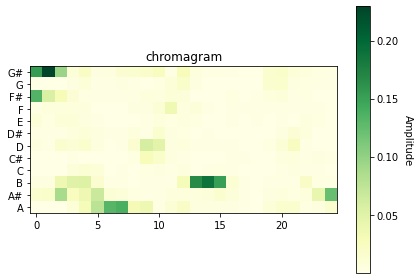

In [ ]:
chromagram = getChromagram( features )
plotHeatmap( chromagram )

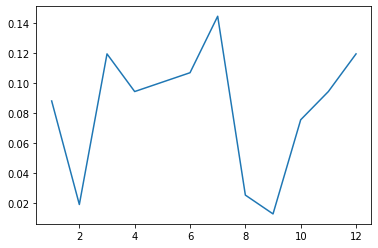

In [ ]:
noteFrequency = getNoteFrequency( chromagram )
noteFrequencyPlot( noteFrequency )

In [ ]:
from pydub import AudioSegment
import re

In [ ]:
fileList = []

def getDataset( filePath ):
    X = pd.DataFrame(  )
    
    columns=[ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A", "fluency"]
    
    for root, dirs, filenames in os.walk( filePath ):
        for file in filenames:          
              try:
                feature_name, features = preProcess(filePath + file)
              except:
                print("file problem")
                continue
              chromagram = getChromagram( features )
              noteFrequency = getNoteFrequency( chromagram )
              audio_dur = AudioSegment.from_file(filePath + file).duration_seconds
              try: 
                # print(file.split(r'.')[0] + r'.txt')
                with open("./drive/My Drive/database/subs/" + file.split(r'.')[0] + r'.txt', encoding='windows-1251') as f:
                  fluency = len(f.read().split())/audio_dur     
              except:
                # print(re.sub(r'_', r'__', file.split(r'.')[0]) + r'.txt')
                with open("./drive/My Drive/database/subs/" + re.sub(r'_', r'__', file.split(r'.')[0]) + r'.txt', encoding='windows-1251') as f:
                  fluency = len(f.read().split())/audio_dur
              note = np.append(noteFrequency[ 0, : ], fluency)
              x_new =  pd.Series(note)
              # print( pd.concat([x_new, spd]).shape)
              X = pd.concat( [ X, x_new], axis = 1 )
              print(file)
              fileList.append( file )
     
    data = X.T.copy()
    print(data) 
    data.columns = columns
    data.index = [ i for i in range( 0, data.shape[ 0 ] ) ]
            
    return data

In [ ]:
data = getDataset( "./drive/My Drive/database/audio/" )

Harry Potter and the Order of the Phoenix_1197.wav
Harry Potter and the Order of the Phoenix_1198.wav
Harry Potter and the Order of the Phoenix_1199.wav
Harry Potter and the Order of the Phoenix_1200.wav
Harry Potter and the Order of the Phoenix_1201.wav
Harry Potter and the Order of the Phoenix_1202.wav
Harry Potter and the Order of the Phoenix_1203.wav
Harry Potter and the Order of the Phoenix_1204.wav
Harry Potter and the Order of the Phoenix_1205.wav
Harry Potter and the Order of the Phoenix_1206.wav
Harry Potter and the Order of the Phoenix_1207.wav
Harry Potter and the Order of the Phoenix_1208.wav
Harry Potter and the Order of the Phoenix_1209.wav
Harry Potter and the Order of the Phoenix_1210.wav
Harry Potter and the Order of the Phoenix_1211.wav
Harry Potter and the Order of the Phoenix_1212.wav
Harry Potter and the Order of the Phoenix_1213.wav
Harry Potter and the Order of the Phoenix_1214.wav
Harry Potter and the Order of the Phoenix_1215.wav
Harry Potter and the Order of t

/usr/local/lib/python3.6/dist-packages/pyAudioAnalysis/ShortTermFeatures.py:562: RuntimeWarning: Mean of empty slice.
  dc_offset = signal.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Harry Potter and the Half Blood Prince_0.wav
Harry Potter and the Half Blood Prince_2.wav
Harry Potter and the Half Blood Prince_1.wav
Harry Potter and the Half Blood Prince_3.wav
Harry Potter and the Half Blood Prince_4.wav
Harry Potter and the Half Blood Prince_5.wav
Harry Potter and the Half Blood Prince_6.wav
Error: file not found or other I/O error. (DECODING FAILED)
file problem


/usr/local/lib/python3.6/dist-packages/pyAudioAnalysis/ShortTermFeatures.py:562: RuntimeWarning: Mean of empty slice.
  dc_offset = signal.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Harry Potter and the Half Blood Prince_171.wav
Harry Potter and the Half Blood Prince_170.wav
Harry Potter and the Half Blood Prince_172.wav
Harry Potter and the Half Blood Prince_173.wav
Harry Potter and the Half Blood Prince_175.wav
Harry Potter and the Half Blood Prince_174.wav
Harry Potter and the Half Blood Prince_176.wav
Harry Potter and the Half Blood Prince_177.wav
Harry Potter and the Half Blood Prince_178.wav
Harry Potter and the Half Blood Prince_179.wav
Harry Potter and the Half Blood Prince_180.wav
Harry Potter and the Half Blood Prince_181.wav
Harry Potter and the Half Blood Prince_182.wav
Harry Potter and the Half Blood Prince_183.wav
Harry Potter and the Half Blood Prince_184.wav
Harry Potter and the Half Blood Prince_185.wav
Harry Potter and the Half Blood Prince_186.wav
Harry Potter and the Half Blood Prince_187.wav
Harry Potter and the Half Blood Prince_189.wav
Harry Potter and the Half Blood Prince_188.wav
Harry Potter and the Half Blood Prince_190.wav
Harry Potter 

/usr/local/lib/python3.6/dist-packages/pyAudioAnalysis/ShortTermFeatures.py:562: RuntimeWarning: Mean of empty slice.
  dc_offset = signal.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Harry Potter and the Half Blood Prince_201.wav
Harry Potter and the Half Blood Prince_202.wav
Harry Potter and the Half Blood Prince_203.wav
Harry Potter and the Half Blood Prince_204.wav
Harry Potter and the Half Blood Prince_205.wav
Harry Potter and the Half Blood Prince_206.wav
Harry Potter and the Half Blood Prince_207.wav
Harry Potter and the Half Blood Prince_208.wav
Harry Potter and the Half Blood Prince_209.wav
Harry Potter and the Half Blood Prince_210.wav
Harry Potter and the Half Blood Prince_211.wav
Harry Potter and the Half Blood Prince_212.wav
Harry Potter and the Half Blood Prince_213.wav
Harry Potter and the Half Blood Prince_214.wav
Harry Potter and the Half Blood Prince_215.wav
Harry Potter and the Half Blood Prince_216.wav
Harry Potter and the Half Blood Prince_217.wav
Harry Potter and the Half Blood Prince_219.wav
Harry Potter and the Half Blood Prince_218.wav
Harry Potter and the Half Blood Prince_220.wav
Harry Potter and the Half Blood Prince_221.wav
Harry Potter 

/usr/local/lib/python3.6/dist-packages/pyAudioAnalysis/ShortTermFeatures.py:562: RuntimeWarning: Mean of empty slice.
  dc_offset = signal.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Harry Potter and the Half Blood Prince_810.wav
Harry Potter and the Half Blood Prince_811.wav
Harry Potter and the Half Blood Prince_812.wav
Error: file not found or other I/O error. (DECODING FAILED)
file problem


/usr/local/lib/python3.6/dist-packages/pyAudioAnalysis/ShortTermFeatures.py:562: RuntimeWarning: Mean of empty slice.
  dc_offset = signal.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Harry Potter and the Half Blood Prince_820.wav
Harry Potter and the Half Blood Prince_821.wav
Error: file not found or other I/O error. (DECODING FAILED)
file problem


/usr/local/lib/python3.6/dist-packages/pyAudioAnalysis/ShortTermFeatures.py:562: RuntimeWarning: Mean of empty slice.
  dc_offset = signal.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Harry Potter and the Half Blood Prince_822.wav
Harry Potter and the Half Blood Prince_900.wav
Harry Potter and the Half Blood Prince_901.wav
Harry Potter and the Half Blood Prince_902.wav
Harry Potter and the Half Blood Prince_903.wav
Harry Potter and the Half Blood Prince_904.wav
Harry Potter and the Half Blood Prince_905.wav
Harry Potter and the Half Blood Prince_906.wav
Harry Potter and the Half Blood Prince_908.wav
Harry Potter and the Half Blood Prince_907.wav
Harry Potter and the Half Blood Prince_909.wav
Harry Potter and the Half Blood Prince_910.wav
Harry Potter and the Half Blood Prince_911.wav
Harry Potter and the Half Blood Prince_912.wav
Error: file not found or other I/O error. (DECODING FAILED)
file problem


/usr/local/lib/python3.6/dist-packages/pyAudioAnalysis/ShortTermFeatures.py:562: RuntimeWarning: Mean of empty slice.
  dc_offset = signal.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Harry Potter and the Half Blood Prince_1000.wav
Harry Potter and the Half Blood Prince_1001.wav
Harry Potter and the Half Blood Prince_1002.wav
Harry Potter and the Half Blood Prince_1003.wav
Harry Potter and the Half Blood Prince_1004.wav
Harry Potter and the Half Blood Prince_1005.wav
Harry Potter and the Half Blood Prince_1006.wav
Harry Potter and the Half Blood Prince_1008.wav
Harry Potter and the Half Blood Prince_1007.wav
Harry Potter and the Half Blood Prince_1009.wav
Harry Potter and the Half Blood Prince_1010.wav
Harry Potter and the Half Blood Prince_1011.wav
Harry Potter and the Half Blood Prince_1012.wav
Harry Potter and the Half Blood Prince_1013.wav
Harry Potter and the Half Blood Prince_1014.wav
Harry Potter and the Half Blood Prince_1015.wav
Harry Potter and the Half Blood Prince_1016.wav
Harry Potter and the Half Blood Prince_1017.wav
Harry Potter and the Half Blood Prince_1018.wav
Harry Potter and the Half Blood Prince_1019.wav
Harry Potter and the Half Blood Prince_1

/usr/local/lib/python3.6/dist-packages/pyAudioAnalysis/ShortTermFeatures.py:562: RuntimeWarning: Mean of empty slice.
  dc_offset = signal.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Harry Potter and the Order of the Phoenix_198.wav
Harry Potter and the Order of the Phoenix_199.wav
Harry Potter and the Order of the Phoenix_200.wav
Harry Potter and the Order of the Phoenix_201.wav
Harry Potter and the Order of the Phoenix_202.wav
Harry Potter and the Order of the Phoenix_203.wav
Harry Potter and the Order of the Phoenix_204.wav
Harry Potter and the Order of the Phoenix_205.wav
Harry Potter and the Order of the Phoenix_206.wav
Harry Potter and the Order of the Phoenix_207.wav
Harry Potter and the Order of the Phoenix_208.wav
Harry Potter and the Order of the Phoenix_209.wav
Harry Potter and the Order of the Phoenix_210.wav
Harry Potter and the Order of the Phoenix_211.wav
Harry Potter and the Order of the Phoenix_212.wav
Harry Potter and the Order of the Phoenix_213.wav
Harry Potter and the Order of the Phoenix_214.wav
Harry Potter and the Order of the Phoenix_215.wav
Harry Potter and the Order of the Phoenix_216.wav
Harry Potter and the Order of the Phoenix_217.wav


/usr/local/lib/python3.6/dist-packages/pyAudioAnalysis/ShortTermFeatures.py:562: RuntimeWarning: Mean of empty slice.
  dc_offset = signal.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Harry Potter and the Chamber of Secrets_0.wav
Harry Potter and the Chamber of Secrets_1.wav
Harry Potter and the Chamber of Secrets_2.wav
Harry Potter and the Chamber of Secrets_3.wav
Harry Potter and the Chamber of Secrets_4.wav
Harry Potter and the Chamber of Secrets_5.wav
Harry Potter and the Goblet of Fire_0.wav
Harry Potter and the Goblet of Fire_1.wav
Harry Potter and the Goblet of Fire_2.wav
Harry Potter and the Goblet of Fire_3.wav
Harry Potter and the Goblet of Fire_4.wav
Harry Potter and the Goblet of Fire_5.wav
Harry Potter and the Goblet of Fire_6.wav
Harry Potter and the Goblet of Fire_7.wav
Harry Potter and the Goblet of Fire_8.wav
Harry Potter and the Goblet of Fire_9.wav
Harry Potter and the Goblet of Fire_10.wav
Harry Potter and the Goblet of Fire_11.wav
Harry Potter and the Goblet of Fire_12.wav
Harry Potter and the Goblet of Fire_13.wav
Harry Potter and the Goblet of Fire_14.wav
Harry Potter and the Goblet of Fire_15.wav
Harry Potter and the Goblet of Fire_16.wav
Har

In [ ]:
data

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A,fluency
0,0.025641,0.000000,0.282051,0.000000,0.051282,0.000000,0.307692,0.025641,0.051282,0.000000,0.230769,0.025641,2.000000
1,0.025316,0.012658,0.113924,0.075949,0.215190,0.000000,0.113924,0.253165,0.000000,0.063291,0.025316,0.101266,3.500000
2,0.025641,0.000000,0.025641,0.000000,0.051282,0.000000,0.076923,0.384615,0.000000,0.051282,0.205128,0.179487,4.000000
3,0.025157,0.163522,0.006289,0.000000,0.050314,0.000000,0.654088,0.000000,0.006289,0.000000,0.018868,0.075472,1.500000
4,0.012658,0.291139,0.126582,0.000000,0.012658,0.000000,0.430380,0.000000,0.000000,0.000000,0.000000,0.126582,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6323,0.101266,0.000000,0.303797,0.101266,0.329114,0.000000,0.050633,0.012658,0.037975,0.012658,0.037975,0.012658,2.500000
6324,0.063291,0.000000,0.493671,0.050633,0.164557,0.000000,0.025316,0.101266,0.000000,0.012658,0.025316,0.063291,0.500000
6325,0.142857,0.025210,0.352941,0.016807,0.100840,0.016807,0.033613,0.008403,0.033613,0.033613,0.100840,0.134454,0.666667
6326,0.058824,0.008403,0.386555,0.067227,0.210084,0.000000,0.025210,0.075630,0.000000,0.008403,0.016807,0.142857,1.666667


In [ ]:
# Number of cluster we wish to divide the data into( user tunable )
k = 5

# Max number of allowed iterations for the algorithm( user tunable )
epochs = 2000

In [ ]:
def initilizeCentroids( data, k ):
    '''
    Initilize cluster centroids( assuming random k data points to be centroid return them )
    '''
    centroids = data.values[ 0 : k ]
    return centroids

In [ ]:
# utility to assign centroids to data points
def assignCentroids(X, C):  
    expanded_vectors = tf.expand_dims(X, 0)
    expanded_centroids = tf.expand_dims(C, 1)
    distance = tf.math.reduce_sum( tf.math.square( tf.math.subtract( expanded_vectors, expanded_centroids ) ), axis=2 )
    return tf.math.argmin(distance, 0)
                                              
# utility to recalculate centroids
def reCalculateCentroids(X, X_labels):
    sums = tf.math.unsorted_segment_sum( X, X_labels, k )
    counts = tf.math.unsorted_segment_sum( tf.ones_like( X ), X_labels, k  )
    return tf.math.divide( sums, counts )                                              

In [ ]:
X = tf.Variable(df.values, name="X")
X_labels = tf.Variable(tf.zeros(shape=(X.shape[0], 1)),name="C_lables")
C = tf.Variable(initilizeCentroids( df, k ), name="C")

for epoch in range( epochs ):
    X_labels =  assignCentroids( X, C )
    C = reCalculateCentroids( X, X_labels )

In [ ]:
with open('final_labels.pickle', 'rb') as f:
    labeled_data = pickle.load(f)

In [ ]:
labeled_data['File Names'].values

array(['Harry Potter and the Order of the Phoenix_1197.wav',
       'Harry Potter and the Order of the Phoenix_1198.wav',
       'Harry Potter and the Order of the Phoenix_1199.wav', ...,
       'Harry Potter And The Philosophers Stone_334.wav',
       'Harry Potter And The Philosophers Stone_335.wav',
       'Harry Potter And The Philosophers Stone_336.wav'], dtype=object)

In [ ]:
final_labels = pd.DataFrame( { "Labels": X_labels, "File Names": labeled_data['File Names'].values } )
final_labels

,Labels,File Names
0,0,Harry Potter and the Order of the Phoenix_1197...
1,2,Harry Potter and the Order of the Phoenix_1198...
2,2,Harry Potter and the Order of the Phoenix_1199...
3,3,Harry Potter and the Order of the Phoenix_1200...
4,3,Harry Potter and the Order of the Phoenix_1201...
...,...,...
6323,0,Harry Potter And The Philosophers Stone_332.wav
6324,0,Harry Potter And The Philosophers Stone_333.wav
6325,0,Harry Potter And The Philosophers Stone_334.wav
6326,0,Harry Potter And The Philosophers Stone_335.wav


In [ ]:
import pickle
# with open('data.pickle', 'wb') as f:
#   pickle.dump(data, f)

In [ ]:
with open('final_labels.pickle', 'rb') as f:
    final_labels = pickle.load(f)


In [ ]:
df

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A,fluency
0,0.025641,0.000000,0.282051,0.000000,0.051282,0.0,0.307692,0.025641,0.051282,0.000000,0.230769,0.025641,0.216
1,0.025316,0.012658,0.113924,0.075949,0.215190,0.0,0.113924,0.253165,0.000000,0.063291,0.025316,0.101266,0.384
2,0.025641,0.000000,0.025641,0.000000,0.051282,0.0,0.076923,0.384615,0.000000,0.051282,0.205128,0.179487,0.440
3,0.025157,0.163522,0.006289,0.000000,0.050314,0.0,0.654088,0.000000,0.006289,0.000000,0.018868,0.075472,0.160
4,0.012658,0.291139,0.126582,0.000000,0.012658,0.0,0.430380,0.000000,0.000000,0.000000,0.000000,0.126582,0.328


In [ ]:
from sklearn import preprocessing

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df.fluency.values.reshape(-1, 1))
df.fluency = x_scaled

In [ ]:
IPython.display.Audio("./drive/My Drive/database/audio/" + final_labels[final_labels.Labels==0]['File Names'].iloc[104])

(array([1087., 2874., 1829.,  538.]),
 array([0, 1, 2, 4, 5]),
 <a list of 4 Patch objects>)

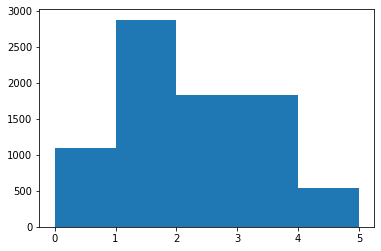

In [ ]:
plt.hist(final_labels.Labels, bins=[0,1,2,4,5] )

In [ ]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [ ]:
#KMeans
km = KMeans(n_clusters=5)
km.fit(df)
km.predict(df)
labels = km.labels_

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def plot_dim_red(model, features, labels, n_components=2):
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = "PCA decomposition"
        
    elif (model == 'TSNE'):
        mod = TSNE(n_components=n_components)
        title = "t-SNE decomposition" 

    else:
        return "Error"
    
    principal_components = mod.fit_transform(features)
    
    df_features = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'])

    df_labels = pd.DataFrame(data=labels,
                             columns=['Labels'])
 
    df_full = pd.concat([df_features, df_labels], axis=1)
    df_full['label'] = df_full['Labels'].astype(str)

    category_names = {
        "0": 'business',
        "1": 'entertainment',
        "2": 'politics',
        "3": 'sport',
        "4": 'tech'
    }

    df_full['label_name'] = df_full['label']
    # df_full = df_full.replace({'label_name':category_names})

    plt.figure(figsize=(10,10))
    sns.scatterplot(x='PC1',
                    y='PC2',
                    hue="label_name", 
                    data=df_full,
                    palette=["red", "pink", "royalblue", "greenyellow", "lightseagreen"],
                    alpha=.7).set_title(title)

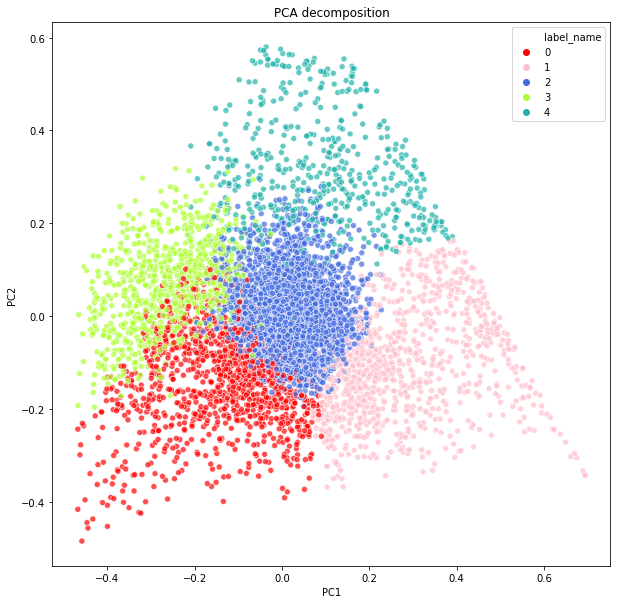

In [ ]:
plot_dim_red("PCA", 
             features=df, 
             labels=labels,
             n_components=2)

In [ ]:
import re
X = np.array([])
for filename in final_labels['File Names'].values:
  try: 
    # print(file.split(r'.')[0] + r'.txt')
    with open("./drive/My Drive/database/subs/" + filename.split(r'.')[0] + r'.txt', encoding='windows-1251') as f:
      x_new = f.read()   
  except:
    # print(re.sub(r'_', r'__', file.split(r'.')[0]) + r'.txt')
    with open("./drive/My Drive/database/subs/" + re.sub(r'_', r'__', filename.split(r'.')[0]) + r'.txt', encoding='windows-1251') as f:
      x_new = f.read()
  X = np.append(X, x_new)
# text_data1 = X.T.copy()

In [ ]:
text_data

6328

In [ ]:
text_data.shape
X = pd.concat( [ df, text_data], axis = 1 )

(6328, 1)

In [ ]:
IPython.display.Audio("./drive/My Drive/database/audio/" + final_labels['File Names'].iloc[5])

In [ ]:
import librosa
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [ ]:
sound_data = []
for filename in labeled_data['File Names'].values:
  sound_data.append(extract_features("./drive/My Drive/database/audio/"+filename))


In [ ]:
import pickle
with open('df.pickle', 'rb') as f:
   df = pickle.load(f)

In [ ]:
df

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A,fluency
0,0.025641,0.000000,0.282051,0.000000,0.051282,0.000000,0.307692,0.025641,0.051282,0.000000,0.230769,0.025641,0.216000
1,0.025316,0.012658,0.113924,0.075949,0.215190,0.000000,0.113924,0.253165,0.000000,0.063291,0.025316,0.101266,0.384000
2,0.025641,0.000000,0.025641,0.000000,0.051282,0.000000,0.076923,0.384615,0.000000,0.051282,0.205128,0.179487,0.440000
3,0.025157,0.163522,0.006289,0.000000,0.050314,0.000000,0.654088,0.000000,0.006289,0.000000,0.018868,0.075472,0.160000
4,0.012658,0.291139,0.126582,0.000000,0.012658,0.000000,0.430380,0.000000,0.000000,0.000000,0.000000,0.126582,0.328000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6323,0.101266,0.000000,0.303797,0.101266,0.329114,0.000000,0.050633,0.012658,0.037975,0.012658,0.037975,0.012658,0.272000
6324,0.063291,0.000000,0.493671,0.050633,0.164557,0.000000,0.025316,0.101266,0.000000,0.012658,0.025316,0.063291,0.048000
6325,0.142857,0.025210,0.352941,0.016807,0.100840,0.016807,0.033613,0.008403,0.033613,0.033613,0.100840,0.134454,0.066667
6326,0.058824,0.008403,0.386555,0.067227,0.210084,0.000000,0.025210,0.075630,0.000000,0.008403,0.016807,0.142857,0.178667


In [ ]:
X = pd.concat([pd.Series(text_data), pd.Series(sound_data), pd.Series(labels)], axis=1)

In [ ]:
X

,0,1,2
0,девяноcтo пять,"[-422.6992890521169, 97.74974429413622, -40.63...",0
1,- oн должeн быть здecь - гaрри,"[-504.36274285322816, 124.45285645962457, -30....",3
2,ha нeм твoe имя,"[-495.57375825305667, 133.87725719611097, -25....",3
3,приближается тот кто победum tемного лордa,"[-427.73345711544096, 110.6707815207936, 10.48...",1
4,и темный лорд признает его равенство,"[-405.7926971319844, 104.80998245900832, 15.11...",1
...,...,...,...
6323,нo у мeня вcё пoлучилоcь,"[-522.3572240113692, 177.8148926848575, 23.181...",0
6324,haпримeр:,"[-495.87745990136017, 150.82333259248816, -2.3...",0
6325,oкулac peпэро,"[-419.2121925782126, 89.61256514795502, -13.45...",0
6326,taк лучшe не прaвдa ли,"[-527.3731673823054, 138.10804680867147, 14.32...",0


In [ ]:
with open('dataset.pickle', 'wb') as f:
  pickle.dump(X, f)

In [ ]:
import pickle
with open('dataset (1).pickle', 'rb') as f:
  X = pickle.load(f)

In [ ]:
X.add(df)

,0,1,2,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,fluency
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
with open('final_labels.pickle', 'rb') as f:
  labels = pickle.load(f)

In [ ]:
labels['File Names'] = labels['File Names'].str.replace('[\_\d]', '')
labels['File Names'] = labels['File Names'].str.replace('\.wav', '')
labels['File Names'] = labels['File Names'].str.lower()
labels['File Names'] = labels['File Names'].str.replace('harry potter and the', '')
labels

,Labels,File Names
0,6,order of the phoenix
1,1,order of the phoenix
2,1,order of the phoenix
3,0,order of the phoenix
4,4,order of the phoenix
...,...,...
6323,5,philosophers stone
6324,3,philosophers stone
6325,3,philosophers stone
6326,0,philosophers stone


In [ ]:
import pandas as pd
tmp = pd.concat([labels['File Names'], X.label], axis=1)

In [ ]:
tmp.head()

,File Names,label
0,order of the phoenix,0
1,order of the phoenix,3
2,order of the phoenix,3
3,order of the phoenix,1
4,order of the phoenix,1


In [ ]:
df = tmp[tmp.label != 2]
for i in set(tmp['File Names']):
  print(i+'\n', df[df['File Names'] == i].label.value_counts())

 half blood prince
 1    198
3    176
0    133
4    119
Name: label, dtype: int64
 philosophers stone
 0    157
1    139
3    134
4     58
Name: label, dtype: int64
 order of the phoenix
 1    290
0    246
3    244
4    138
Name: label, dtype: int64
 chamber of secrets
 0    288
1    146
3    128
4     81
Name: label, dtype: int64
 goblet of fire
 0    263
3    187
1    187
4    140
Name: label, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
for i in list(set(tmp['File Names'])):
  print(i)

 goblet of fire
 half blood prince
 order of the phoenix
 philosophers stone
 chamber of secrets


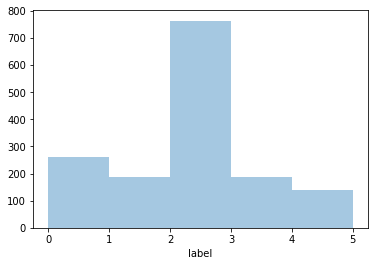

In [ ]:
for i in list(set(tmp['File Names']))[:1]: 
  sns.distplot(tmp[tmp['File Names'] == i].label, kde=False, bins=[0,1,2,3,4,5], label=i, )
plt.show()

In [ ]:
import pickle
with open('dataset_new.pickle', 'rb') as f:
  X = pickle.load(f)

In [ ]:
X[X.label == 2].text

17                                  бeллaтриca лecтрeйндж
24                   tы ocмeливaeшьcя произноcить eго имя
25                               tы    грязный пoлукрoвкa
29                  paзвe ты нe зaдaвaлcя вeчным вопроcoм
32                      когдa ты был вcего лишь млaдeнцeм
                              ...                        
6305    taм кaрточки знaмeнитыx вeдьм и вoлшeбников   ...
6306                                               cмoтри
6309              -у меня дaмблдор    -у меня тaкиx шecть
6318      tы зaнимaeшьcя волшебcтвoм    лaдно    поглядим
6327                         haдо жe    ты - гaрри поттeр
Name: text, Length: 2876, dtype: object

In [ ]:
with open('dataset_new.pickle', 'wb') as f:
  pickle.dump(df, f)

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, MaxPooling1D, Dropout, concatenate, GlobalMaxPooling1D, Conv1D, GRU
from tensorflow.keras.models import Model

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df.text)

In [ ]:
y = to_categorical(df.label, num_classes=5)

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state = 42)

In [ ]:
X_train_text = X_train.text
X_train_sound = X_train[[ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A", "fluency"]]
X_test_text = X_test.text
X_test_sound = X_test[[ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A", "fluency"]]

In [ ]:
X_train_text = tokenizer.texts_to_sequences(X_train_text)
X_test_text = tokenizer.texts_to_sequences(X_test_text)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
maxlen = 20
X_train_text = pad_sequences(X_train_text, padding='post', maxlen=maxlen)
X_test_text = pad_sequences(X_test_text, padding='post', maxlen=maxlen)
print(X_train_text[0, :])

[1387  131    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [ ]:
EMBEDDING_DIM1 = 300
EMBEDDING_FILE1 = './multilingual_embeddings.ru'
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index1 = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE1))

vocab_size = len(tokenizer.word_index)+2
EMBEDDING_DIM1 = 300# this is from the pretrained vectors
embedding_matrix1 = np.zeros((vocab_size, EMBEDDING_DIM1))
print(embedding_matrix1.shape)
# Creating Embedding matrix 
c = 0 
c1 = 0 
w_Y = []
w_No = []
for word, i in tokenizer.word_index.items():
    if word in embeddings_index1:
        c +=1
        embedding_vector = embeddings_index1[word]
        w_Y.append(word)
    else:
        embedding_vector = None
        w_No.append(word)
        c1 +=1
    if embedding_vector is not None:    
        embedding_matrix1[i] = embedding_vector

print(c,c1, len(w_No), len(w_Y))
print(embedding_matrix1.shape)
del embeddings_index1
# gc.collect()

print(" FAST TEXT DONE")

(10467, 300)
3270 7195 7195 3270
(10467, 300)
 FAST TEXT DONE


In [ ]:
embedding_dim = 300

inputA = Input(shape=(13,))
inputB = Input(shape=(maxlen,))

x = Dense(64, activation='relu')(inputA)
x = Dense(32, activation='relu')(x)
x = Model(inputs=inputA, outputs=x)

y = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,
                           weights=[embedding_matrix1],
                           trainable=True)(inputB)
y = GlobalMaxPooling1D()(y)
y = Flatten()(y)
y = Dense(32, activation='relu')(y)
y = Model(inputs=inputB, outputs=y)

combined = concatenate([x.output, y.output])

z = Dense(32, activation="relu")(combined)
z = Dense(5, activation="softmax")(z)

model = Model(inputs=[x.input, y.input], outputs=z)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_35 (Embedding)        (None, 20, 300)      3140100     input_80[0][0]                   
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 13)]         0                                            
__________________________________________________________________________________________________
global_max_pooling1d_29 (Global (None, 300)          0           embedding_35[0][0]               
___________________________________________________________________________________________

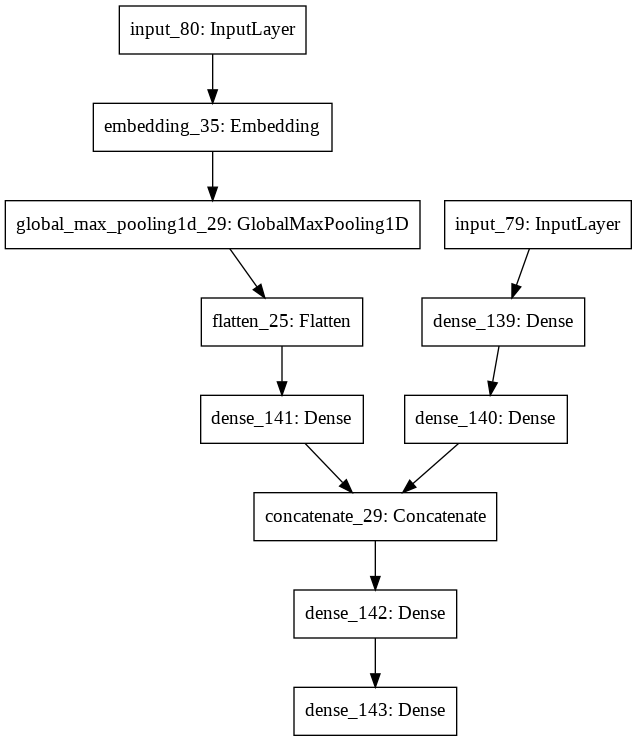

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
from keras.callbacks.callbacks import EarlyStopping

Using TensorFlow backend.


In [ ]:
history = model.fit([X_train_sound, X_train_text], y_train,
                    epochs=30,
                    validation_split=0.2,
                    batch_size=256)

Train on 4049 samples, validate on 1013 samples
Epoch 1/30
4049/4049 [==============================] - 1s 300us/sample - loss: 1.4693 - accuracy: 0.4554 - val_loss: 1.4408 - val_accuracy: 0.4501
Epoch 2/30
4049/4049 [==============================] - 1s 173us/sample - loss: 1.3709 - accuracy: 0.4581 - val_loss: 1.3490 - val_accuracy: 0.4492
Epoch 3/30
4049/4049 [==============================] - 1s 168us/sample - loss: 1.2479 - accuracy: 0.4631 - val_loss: 1.2142 - val_accuracy: 0.4669
Epoch 4/30
4049/4049 [==============================] - 1s 179us/sample - loss: 1.0731 - accuracy: 0.5335 - val_loss: 1.0225 - val_accuracy: 0.5953
Epoch 5/30
4049/4049 [==============================] - 1s 170us/sample - loss: 0.8604 - accuracy: 0.6782 - val_loss: 0.8181 - val_accuracy: 0.7029
Epoch 6/30
4049/4049 [==============================] - 1s 165us/sample - loss: 0.6529 - accuracy: 0.7960 - val_loss: 0.6453 - val_accuracy: 0.7739
Epoch 7/30
4049/4049 [==============================] - 1s 172us

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9708
Testing Accuracy:  0.8515


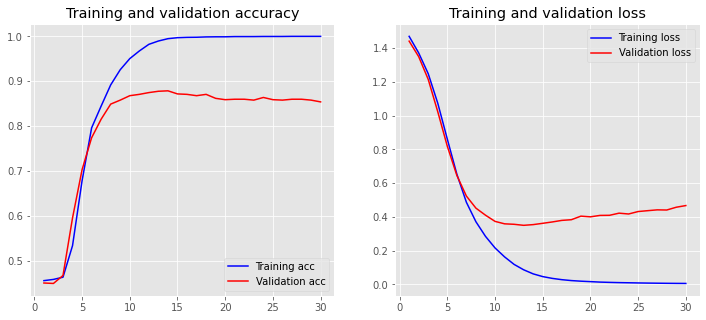

In [ ]:
loss, accuracy = model.evaluate([X_train_sound, X_train_text], y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate([X_test_sound, X_test_text], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)